In [65]:
# Import libaries
import numpy as np                       # Math
import matplotlib.pyplot as plt          # Plots
from scipy.optimize import fsolve        # Numerically solve equations
from IPython.display import clear_output # Display settings
import time                              # Record time

from scipy.sparse import diags


In [66]:
# ==== INPUT PARAMETERS =====
length, height = 19,19 # cm
h = 0.5 # cm. Grid spacing.
nx,ny = int(length/h +1), int(height/h + 1)

x,y = np.arange(0,length+h,h), np.arange(0,height+h,h)
X,Y = np.meshgrid(x,y,indexing="xy")

V = np.empty((nx,ny))
b = np.zeros_like(V)
bflat = b[1:-1,1:-1].flatten("C")



In [67]:
def d2_mat_dirichlet_2d(nx,ny,h):
    a = 1.0 / h**2
    c = -4.0*a

    diag_a = a * np.ones((nx-2)*(ny-2)-1)
    diag_a[nx-3::nx-2] = 0.0
    diag_g = a * np.ones((nx-2)*(ny-3))
    diag_c = c * np.ones((nx-2)*(ny-2))

    diagonals = [diag_g, diag_a, diag_c, diag_a, diag_g]
    offsets = [-(nx-2), -1, 0, 1, nx-2]

    d2mat = diags(diagonals, offsets).toarray()

    return d2mat

In [ ]:
A = d2_mat_dirichlet_2d(nx,ny,h)
Ainv = np.linalg.inv(A)
Vvec = np.reshape(np.dot(Ainv,bflat), (nx-2,ny-2), order="C")
V[1:-1,1:-1] = Vvec
V[0,:], V[-1,:], V[:,0], V[-1,:] = 0,0,0,0

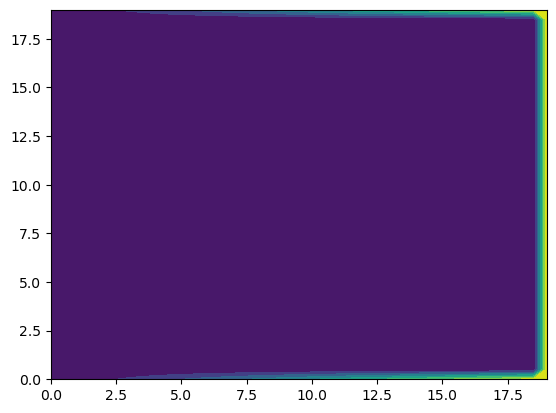

In [74]:
fig,ax = plt.subplots()
ax.contourf(X,Y,V)

In [ ]:

cat_pos_x = slice(int(7//h), int(8//h))
ano_pos_x = slice(int(11//h), int(12//h))

cat_pos_y = slice(int(8//h), int(19//h))
ano_pos_y = slice(int(8//h), int(19//h))


cat_pot = 0
ano_pot = 1.8

# ========================================================================

# Only for plotting electrode positions
V[cat_pos_x, cat_pos_y] = 1  
V[ano_pos_x, ano_pos_y] = 1  

fig,ax = plt.subplots()

ax.imshow(V.transpose(), cmap="binary")
ax.invert_yaxis()

ax.set_xlabel('Width / X: Distance [5 mm]')
ax.set_ylabel('Length / Y: Distance [5 mm]')
ax.set_title('Electrode position')

plt.show()

# # Restets V
V = np.zeros_like(V)

# # Makes values closer to final values to improve convergation time
V += (ano_pot + cat_pot) / 2          # Makes all values equal to the middle value of anode and cathode
V[:, :cat_pos_y.start] = cat_pot   # Makes all values behind cathode equal to cathode
V[:, ano_pos_y.stop:] = ano_pot    # Makes all values behind anode equal to anode

# # Defines cathode and anode potentials
V[cat_pos_x, cat_pos_y] = cat_pot  
V[ano_pos_x, ano_pos_y] = ano_pot  

# # Sets boundary equal to catode potenital
V[   0, :] = cat_pot
V[  -1, :] = cat_pot
V[:,    0] = cat_pot
V[:,   -1] = cat_pot

# # Create mask to know position of electrodes
mask = np.zeros_like(V, dtype=bool)
mask[cat_pos_x, cat_pos_y] = True
mask[ano_pos_x, ano_pos_y] = True



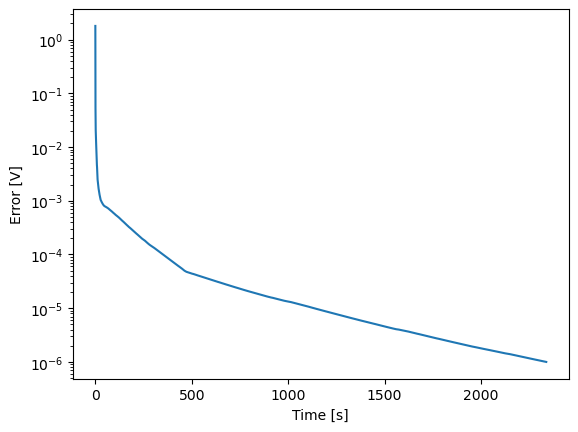

Number of loops: 4616
Time: 2338.0 s
 
Cathode front area    = 88 cm2
Total cathode current = 235.3 A
Total anode current   = 235.4 A
Current density       = 2674 mA/cm2
 
Front average         = 2260 mA/cm2
Front max             = 2742 mA/cm2
Front min             = 2181 mA/cm2
Back average          = 414 mA/cm2
Back max              = 1375 mA/cm2
Back min              = 159 mA/cm2
 


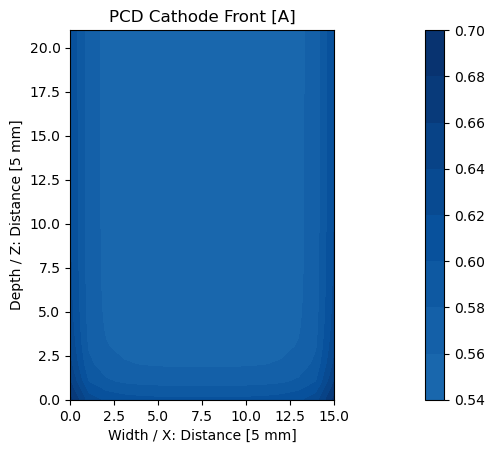

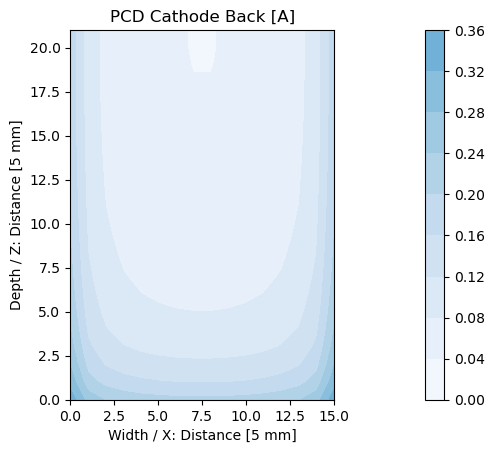

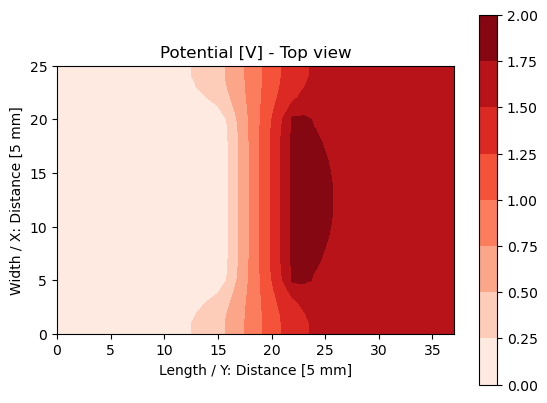

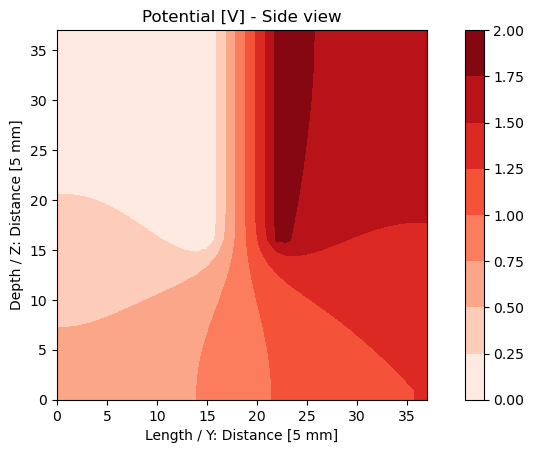

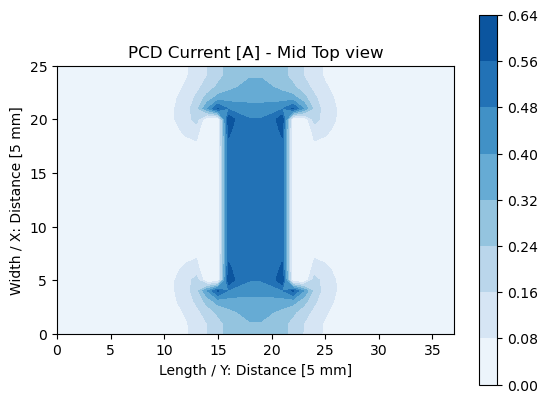

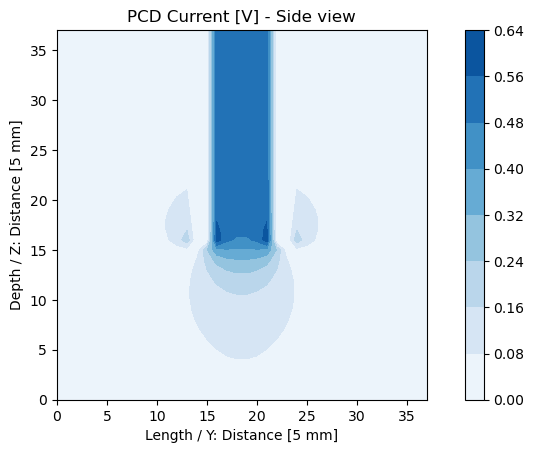

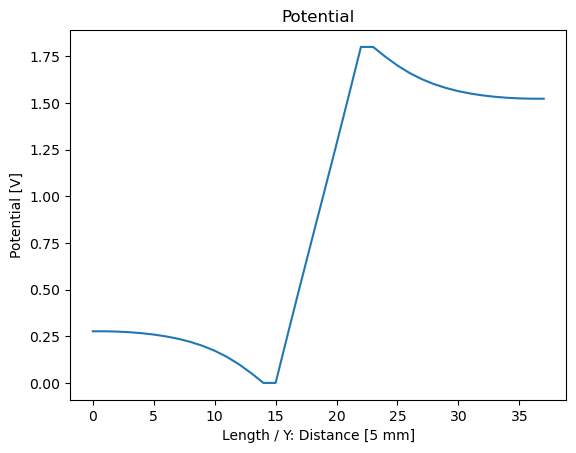

In [62]:
# ==== Calculates the primary current distribution ====
# Only considers geometry and conductivity of melt
#V = V_pcd
# Parameters for recording
max_loops = 1000000
tol = 1e-6     
err = 2 * tol
cou = 0
err_list = []
ti_list = []
start_time = time.time()

# Calculation start
while err > tol:
    
    V_old = V.copy() # Copy for error calculation

    
    # ========
    laplace() # Calculates laplace from function
    # ========

    
    # Recording of progress
    err  = np.max(np.abs(V - V_old)) 
    elapsed_time = time.time() - start_time
    ti_list.append(elapsed_time)
    err_list.append(err)
    cou += 1

    # Plotting of error
    clear_output(wait=True)
    plt.plot(ti_list,err_list)
    plt.ylabel('Error [V]')
    plt.xlabel('Time [s]')
    plt.yscale('log')
    plt.show()

    # Fail safe
    if cou > max_loops:
        print(f'Laplace error at outer loop {count}')
        break

# Final recordings
clear_output(wait=True)
plt.plot(ti_list,err_list)
plt.ylabel('Error [V]')
plt.xlabel('Time [s]')
plt.yscale('log')
plt.show()
print(f'Number of loops: {cou}')
print(f'Time: {np.round(ti_list[-1], 0)} s')

# Set edge values

outside_values()

# Saves potential 
V_pcd = V.copy()

# Calculates current from potential
I_pcd = current()

# Records electrode surface current density distribution
cur_cat_fro_pcd  = I_pcd[cat_pos_x, cat_pos_y.stop,      cat_pos_z] # A/(5mm)^2
cur_cat_back_pcd = I_pcd[cat_pos_x, cat_pos_y.start - 1, cat_pos_z] # A/(5mm)^2
cur_ano_fro_pcd  = I_pcd[ano_pos_x, ano_pos_y.start - 1, ano_pos_z] # A/(5mm)^2
cur_ano_back_pcd = I_pcd[ano_pos_x, ano_pos_y.stop,      ano_pos_z] # A/(5mm)^2

# Statistics

area_cat_fro = 0.25 * ((cat_pos_x.stop - cat_pos_x.start) * (cat_pos_z.stop - cat_pos_z.start)) # cm2
tot_cat_cur_pcd = np.sum(cur_cat_fro_pcd) + np.sum(cur_cat_back_pcd) # A
tot_ano_cur_pcd = np.sum(cur_ano_fro_pcd) + np.sum(cur_ano_back_pcd) # A
cd_cat_pcd = 1000 * tot_cat_cur_pcd / (area_cat_fro) # mA/cm2 - we only consider front area when calculating CD

print(' ')
print(f'Cathode front area    = {area_cat_fro:.0f} cm2')
print(f'Total cathode current = {tot_cat_cur_pcd:.1f} A')
print(f'Total anode current   = {tot_ano_cur_pcd:.1f} A')
print(f'Current density       = {cd_cat_pcd:.0f} mA/cm2')
print(' ')
print(f'Front average         = {(1000/0.25)*np.mean(cur_cat_fro_pcd):.0f} mA/cm2')
print(f'Front max             = {(1000/0.25)*np.max(cur_cat_fro_pcd):.0f} mA/cm2')
print(f'Front min             = {(1000/0.25)*np.min(cur_cat_fro_pcd):.0f} mA/cm2')
print(f'Back average          = {(1000/0.25)*np.mean(cur_cat_back_pcd):.0f} mA/cm2')
print(f'Back max              = {(1000/0.25)*np.max(cur_cat_back_pcd):.0f} mA/cm2')
print(f'Back min              = {(1000/0.25)*np.min(cur_cat_back_pcd):.0f} mA/cm2')
print(' ')

# Plotting (See titles)
plt.contourf(np.transpose(cur_cat_fro_pcd), cmap = 'Blues')
plt.colorbar()
plt.clim(0,0.7)
plt.axis('scaled')
plt.title('PCD Cathode Front [A]')
plt.xlabel('Width / X: Distance [5 mm]')
plt.ylabel('Depth / Z: Distance [5 mm]')
plt.show()
plt.close()

plt.contourf(np.transpose(cur_cat_back_pcd), cmap = 'Blues')
plt.colorbar()
plt.clim(0,0.7)
plt.axis('scaled')
plt.title('PCD Cathode Back [A]')
plt.xlabel('Width / X: Distance [5 mm]')
plt.ylabel('Depth / Z: Distance [5 mm]')
plt.show()
plt.close()

plt.contourf(V_pcd[:,:,-1], cmap='Reds')
plt.colorbar()
plt.axis('scaled')
plt.title('Potential [V] - Top view')
plt.xlabel('Length / Y: Distance [5 mm]')
plt.ylabel('Width / X: Distance [5 mm]')
plt.show()
plt.close()


plt.contourf(np.transpose(V_pcd[x//2,:,:]), cmap='Reds')
plt.colorbar()
plt.axis('scaled')
plt.title('Potential [V] - Side view')
plt.xlabel('Length / Y: Distance [5 mm]')
plt.ylabel('Depth / Z: Distance [5 mm]')
plt.show()
plt.close()

plt.contourf(I_pcd[:,:,-1*int((cat_pos_z.stop - cat_pos_z.start)/2)], cmap='Blues')
plt.colorbar()
plt.clim(0,0.7)
plt.axis('scaled')
plt.title('PCD Current [A] - Mid Top view')
plt.xlabel('Length / Y: Distance [5 mm]')
plt.ylabel('Width / X: Distance [5 mm]')
plt.show()
plt.close()

plt.contourf(np.transpose(I_pcd[x//2,:,:]), cmap='Blues')
plt.colorbar()
plt.clim(0,0.7)
plt.axis('scaled')
plt.title('PCD Current [V] - Side view')
plt.xlabel('Length / Y: Distance [5 mm]')
plt.ylabel('Depth / Z: Distance [5 mm]')
plt.show()
plt.close()


plt.plot(V_pcd[x//2, : , z//2])
plt.xlabel('Length / Y: Distance [5 mm]')
plt.ylabel('Potential [V]')
plt.title('Potential')
plt.show()

In [63]:
# Functions for calculating overpotentials
# sop = surface overpotential

#Cathode
def cathode_sop(surface): # Takes in front or back cathode surface
    overpotential = surface.copy()

    # Goes trough all points on surface
    for k in range(len(overpotential)):
        for i in range(len(overpotential[0])):
            # --------Function for SOP-CD relation -----------
            overpotential[k][i] = 0.3*surface[k][i] 
            # ------------------------------------------------
    return np.array(overpotential)

#Cathode
def anode_sop(surface): # Takes in front or back anode surface
    overpotential = surface.copy()

    # Goes trough all points on surface
    for k in range(len(overpotential)):
        for i in range(len(overpotential[0])):
            # --------Function for SOP-CD relation -----------
            overpotential[k][i] = 0.8*surface[k][i] 
            # ------------------------------------------------
    return np.array(overpotential)

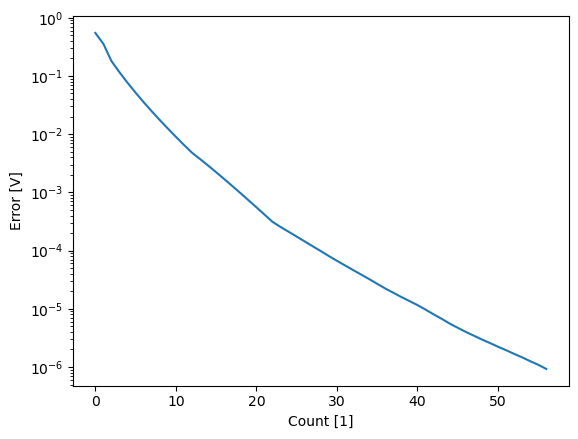

 
Cathode front area    = 88 cm2
Total cathode current = 184.6 A
Total anode current   = 191.0 A
Current density       = 2098 mA/cm2
 
Front average         = 1693 mA/cm2
Front max             = 1993 mA/cm2
Front min             = 1639 mA/cm2
Back average          = 404 mA/cm2
Back max              = 1122 mA/cm2
Back min              = 175 mA/cm2


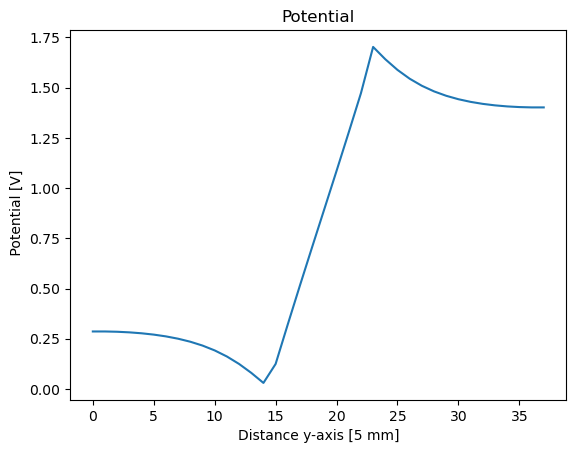

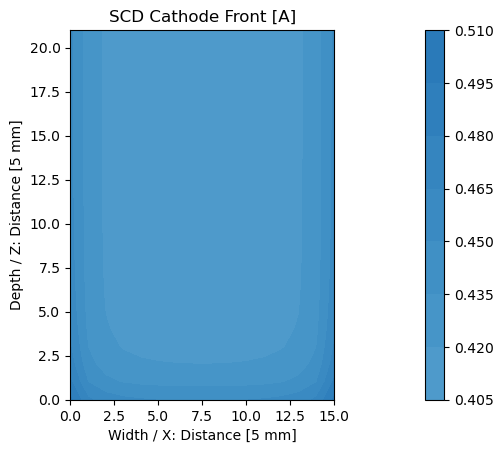

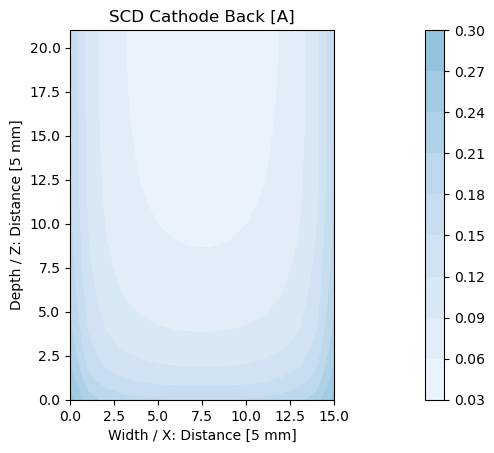

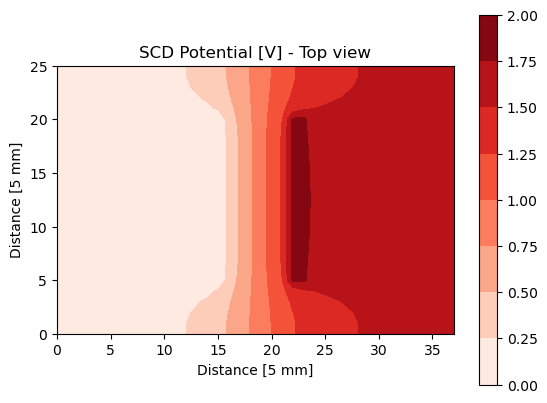

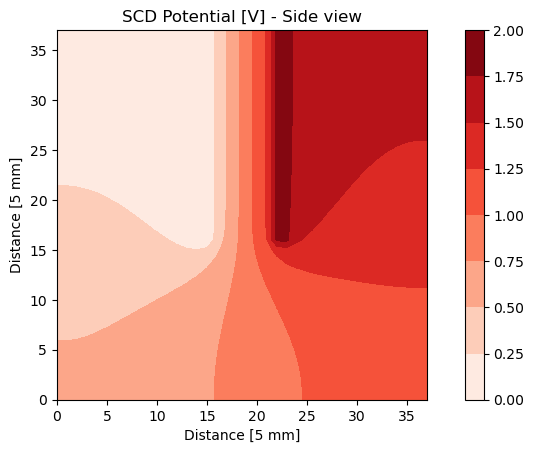

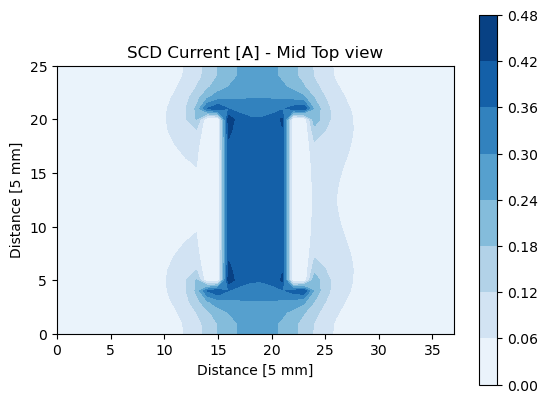

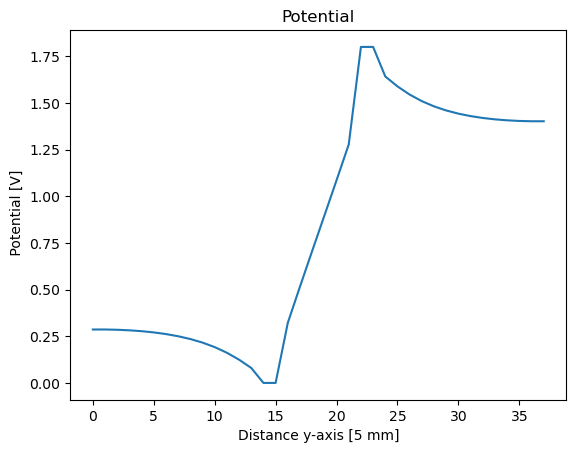

In [66]:
# ===== Calculates the Secondary current distribution =====
# Only considers geometry, conductivity and overpotentials

# Parameters for recording outer loop
V = V_pcd.copy()
tolerance = 1e-6    
error     = 2 * tolerance    
count     = 0
max_loops = 1000000
error_list = []

# Outer loop: Butler volmer calculations
while error > tolerance:

    # Copy for Butler Volmer error calculation
    V_out = V.copy()

    # Parameters for recording inner loop
    tol = 1e-6    
    err = 2 * tol
    cou = 0
    
    # ------------------------------
    # Inner loop: Laplace calculations
    while err > tol:

        V_old = V.copy() # Copy for error calculation

        laplace() # Calculates laplace from function
    
        # Error calculation and fail-safe
        err  = np.max(np.abs(V - V_old))
        cou += 1
        if cou > max_loops:
            print(f'Laplace error at outer loop {count}')
            break
    if cou-1 > max_loops:
        print(f'Laplace error at outer loop {count}')
        break
    # ------------------------------

    
    # Set edge values
    
    outside_values()
        
    # Current calculation from potential distribution
    I_scd = current()

    # Records current current distribution on electrodes
    cur_cat_fro_scd  = I_scd[cat_pos_x, cat_pos_y.stop,      cat_pos_z]
    cur_cat_back_scd = I_scd[cat_pos_x, cat_pos_y.start - 1, cat_pos_z]
    cur_ano_fro_scd  = I_scd[ano_pos_x, ano_pos_y.start - 1, ano_pos_z]
    cur_ano_back_scd = I_scd[ano_pos_x, ano_pos_y.stop,      ano_pos_z]

    # Calculates surface overpotential from current and updates potentials

    V[cat_pos_x, cat_pos_y.stop - 1, cat_pos_z] = cat_pot + cathode_sop(cur_cat_fro_scd)
    V[cat_pos_x, cat_pos_y.start,    cat_pos_z] = cat_pot + cathode_sop(cur_cat_back_scd)
    V[ano_pos_x, ano_pos_y.start,   ano_pos_z] = ano_pot - anode_sop(cur_ano_fro_scd)
    V[ano_pos_x, ano_pos_y.stop -1, ano_pos_z] = ano_pot - anode_sop(cur_ano_back_scd)


    # Error calculation and fail-safe
    error  = np.max(np.abs(V - V_out))
    error_list.append(error)
    count += 1

    # Plot current error
    clear_output(wait=True)
    plt.plot(error_list)
    plt.ylabel('Error [V]')
    plt.xlabel('Count [1]')
    plt.yscale('log')
    plt.show()
    
    if count > max_loops:
        print(f'Butler volmer error at outer loop {count}')
        break

# Plot final error
clear_output(wait=True)
plt.plot(error_list)
plt.ylabel('Error [V]')
plt.xlabel('Count [1]')
plt.yscale('log')
plt.show()


# Set edge values

outside_values()

# Calculates current from potential distribution
I_scd = current()

# Records electrode surface current density distribution
cur_cat_fro_scd  = I_scd[cat_pos_x, cat_pos_y.stop,      cat_pos_z] # A/(5mm)^2
cur_cat_back_scd = I_scd[cat_pos_x, cat_pos_y.start - 1, cat_pos_z] # A/(5mm)^2
cur_ano_fro_scd  = I_scd[ano_pos_x, ano_pos_y.start - 1, ano_pos_z] # A/(5mm)^2
cur_ano_back_scd = I_scd[ano_pos_x, ano_pos_y.stop,      ano_pos_z] # A/(5mm)^2


# Statistics

area_cat_fro = 0.25 * ((cat_pos_x.stop - cat_pos_x.start) * (cat_pos_z.stop - cat_pos_z.start)) # cm2
tot_cat_cur_scd = np.sum(cur_cat_fro_scd) + np.sum(cur_cat_back_scd) # A
tot_ano_cur_scd = np.sum(cur_ano_fro_scd) + np.sum(cur_ano_back_scd) # A
cd_ano_scd = 1000 * tot_cat_cur_scd / (area_cat_fro) # mA/cm2 - we only consider front area when calculating CD

print(' ')
print(f'Cathode front area    = {area_cat_fro:.0f} cm2')
print(f'Total cathode current = {tot_cat_cur_scd:.1f} A')
print(f'Total anode current   = {tot_ano_cur_scd:.1f} A')
print(f'Current density       = {cd_ano_scd:.0f} mA/cm2')
print(' ')
print(f'Front average         = {(1000/0.25)*np.mean(cur_cat_fro_scd):.0f} mA/cm2')
print(f'Front max             = {(1000/0.25)*np.max(cur_cat_fro_scd):.0f} mA/cm2')
print(f'Front min             = {(1000/0.25)*np.min(cur_cat_fro_scd):.0f} mA/cm2')
print(f'Back average          = {(1000/0.25)*np.mean(cur_cat_back_scd):.0f} mA/cm2')
print(f'Back max              = {(1000/0.25)*np.max(cur_cat_back_scd):.0f} mA/cm2')
print(f'Back min              = {(1000/0.25)*np.min(cur_cat_back_scd):.0f} mA/cm2')

plt.plot(V[x//2, : , z//2])
plt.xlabel('Distance y-axis [5 mm]')
plt.ylabel(' Potential [V]')
plt.title('Potential')
plt.show()

# Sets electrode potential back to actual values
V[cat_pos_x, cat_pos_y, cat_pos_z] = cat_pot  
V[ano_pos_x, ano_pos_y, ano_pos_z] = ano_pot

# Saves copy of potential
V_scd = V.copy()

# Plotting (See titles)
plt.contourf(np.transpose(cur_cat_fro_scd), cmap = 'Blues')
plt.colorbar()
plt.clim(0,0.7)
plt.axis('scaled')
plt.title('SCD Cathode Front [A]')
plt.xlabel('Width / X: Distance [5 mm]')
plt.ylabel('Depth / Z: Distance [5 mm]')
plt.show()
plt.close()

plt.contourf(np.transpose(cur_cat_back_scd), cmap = 'Blues')
plt.colorbar()
plt.clim(0,0.7)
plt.axis('scaled')
plt.title('SCD Cathode Back [A]')
plt.xlabel('Width / X: Distance [5 mm]')
plt.ylabel('Depth / Z: Distance [5 mm]')
plt.show()
plt.close()

plt.contourf(V_scd[:,:,-1], cmap='Reds')
plt.colorbar()
plt.axis('scaled')
plt.title('SCD Potential [V] - Top view')
plt.xlabel('Distance [5 mm]')
plt.ylabel('Distance [5 mm]')
plt.show()
plt.close()


plt.contourf(np.transpose(V_scd[x//2,:,:]), cmap='Reds')
plt.colorbar()
plt.axis('scaled')
plt.title('SCD Potential [V] - Side view')
plt.xlabel('Distance [5 mm]')
plt.ylabel('Distance [5 mm]')
plt.show()
plt.close()

plt.contourf(I_scd[:,:,-1*int((cat_pos_z.stop - cat_pos_z.start)/2)], cmap='Blues')
plt.colorbar()
plt.axis('scaled')
plt.title('SCD Current [A] - Mid Top view')
plt.xlabel('Distance [5 mm]')
plt.ylabel('Distance [5 mm]')
plt.show()
plt.close()


plt.plot(V_scd[x//2, : , z//2])
plt.xlabel('Distance y-axis [5 mm]')
plt.ylabel(' Potential [V]')
plt.title('Potential')
plt.show()